# Title: "Predictive Modeling of Procurement Items using Kraljic Matrix Classification"


### Dataset Description

##### The dataset contains key procurement-related features for various products and suppliers. It is designed to facilitate the classification of procurement items into Kraljic categories (Strategic, Leverage, Bottleneck, Non-critical) based on risk and profit impact.

### Purpose:

##### The dataset supports predictive modeling to automate the Kraljic category classification, enabling procurement teams to prioritize supplier management and mitigate supply risks efficiently.

In [7]:
!pip install category_encoders

In [8]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 5.7 MB/s eta 0:00:13
   - -------------------------------------- 1.8/72.0 MB 5.3 MB/s eta 0:00:14
   - -------------------------------------- 2.9/72.0 MB 4.8 MB/s eta 0:00:15
   - -------------------------------------- 3.4/72.0 MB 4.3 MB/s eta 0:00:17
   -- ------------------------------------- 4.2/72.0 MB 4.1 MB/s eta 0:00:17
   -- ------------------------------------- 5.0/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 5.8/72.0 MB 4.0 MB/s eta 0:00:17
   --- ------------------------------------ 6.8/72.0 MB 4.1 MB/s eta 0:00:17
   ---- ----------------------------------- 7.6/72.0 MB 4.1 MB/s eta 0:00:16
   ---- ----------------------------------- 8.7/72.0 MB 4.1 MB/s eta 0:00:16
   ----- ---------------------------------- 9.4/72.0 MB 4.1 MB/s eta 0:00:16
   ----- ---------------------------------- 10.7/72.0 MB 4.2 MB/s eta 0:00:15
   --

In [10]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [13]:
df = pd.read_csv('realistic_kraljic_dataset.csv')

In [14]:
df.head()

,Product_ID,Product_Name,Supplier_Region,Lead_Time_Days,Order_Volume_Units,Cost_per_Unit,Supply_Risk_Score,Profit_Impact_Score,Environmental_Impact,Single_Source_Risk,Kraljic_Category
0,P001,Semiconductors,South America,81,171,255.03,5,5,4,Yes,Strategic
1,P002,Semiconductors,South America,8,763,380.33,5,4,4,Yes,Strategic
2,P003,Pharma APIs,Asia,65,413,385.24,4,5,5,Yes,Strategic
3,P004,Semiconductors,South America,70,882,287.64,5,5,5,Yes,Strategic
4,P005,Lithium Batteries,Asia,15,120,382.26,4,4,4,Yes,Strategic


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product_ID            1000 non-null   object 
 1   Product_Name          1000 non-null   object 
 2   Supplier_Region       1000 non-null   object 
 3   Lead_Time_Days        1000 non-null   int64  
 4   Order_Volume_Units    1000 non-null   int64  
 5   Cost_per_Unit         1000 non-null   float64
 6   Supply_Risk_Score     1000 non-null   int64  
 7   Profit_Impact_Score   1000 non-null   int64  
 8   Environmental_Impact  1000 non-null   int64  
 9   Single_Source_Risk    1000 non-null   object 
 10  Kraljic_Category      1000 non-null   object 
dtypes: float64(1), int64(5), object(5)
memory usage: 86.1+ KB


In [16]:
df.isnull().sum()

Product_ID              0
Product_Name            0
Supplier_Region         0
Lead_Time_Days          0
Order_Volume_Units      0
Cost_per_Unit           0
Supply_Risk_Score       0
Profit_Impact_Score     0
Environmental_Impact    0
Single_Source_Risk      0
Kraljic_Category        0
dtype: int64

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df = df.drop(['Product_ID'],axis = 1)

# Exploratory Data Analysis (EDA)

In [19]:
df.columns

Index(['Product_Name', 'Supplier_Region', 'Lead_Time_Days',
       'Order_Volume_Units', 'Cost_per_Unit', 'Supply_Risk_Score',
       'Profit_Impact_Score', 'Environmental_Impact', 'Single_Source_Risk',
       'Kraljic_Category'],
      dtype='object')

In [20]:
df['Supplier_Region'].unique()

array(['South America', 'Asia', 'Africa', 'Europe', 'North America',
       'Global'], dtype=object)

In [21]:
df['Kraljic_Category'].unique()

array(['Strategic', 'Bottleneck', 'Leverage', 'Non-Critical'],
      dtype=object)

In [22]:
df['Product_Name'].unique()

array(['Semiconductors', 'Pharma APIs', 'Lithium Batteries', 'AI Chips',
       'Customized Valves', 'Rare Earth Metals', 'Specialty Gases',
       'Catalysts', 'Standard Bolts', 'PVC Pipes', 'Packaging Material',
       'Steel Beams', 'Cleaning Supplies', 'Uniforms', 'Printer Ink',
       'Office Stationery'], dtype=object)

In [23]:
number_count = df['Single_Source_Risk'].value_counts()
number_count

Single_Source_Risk
No     560
Yes    440
Name: count, dtype: int64

In [24]:
Environmental_Impact_vs_Kraljic_Category = pd.crosstab(df['Environmental_Impact'], df['Kraljic_Category'], normalize='index') * 100
print(Environmental_Impact_vs_Kraljic_Category)

Kraljic_Category      Bottleneck   Leverage  Non-Critical   Strategic
Environmental_Impact                                                 
1                       0.000000  51.914894     48.085106    0.000000
2                       0.000000  48.301887     51.698113    0.000000
3                     100.000000   0.000000      0.000000    0.000000
4                      52.653061   0.000000      0.000000   47.346939
5                       0.000000   0.000000      0.000000  100.000000


In [25]:
Environmental_Impact_vs_Kraljic_Category = pd.crosstab(df['Supplier_Region'], df['Kraljic_Category'], normalize='index') * 100
print(Environmental_Impact_vs_Kraljic_Category)

Kraljic_Category  Bottleneck    Leverage  Non-Critical   Strategic
Supplier_Region                                                   
Africa              0.000000    0.000000           0.0  100.000000
Asia               37.918216   28.252788           0.0   33.828996
Europe             65.486726   34.513274           0.0    0.000000
Global              0.000000    0.000000         100.0    0.000000
North America       0.000000  100.000000           0.0    0.000000
South America       0.000000    0.000000           0.0  100.000000


# Data visualizations

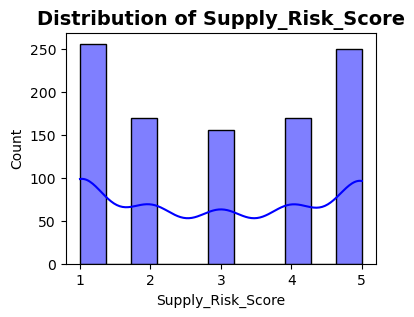

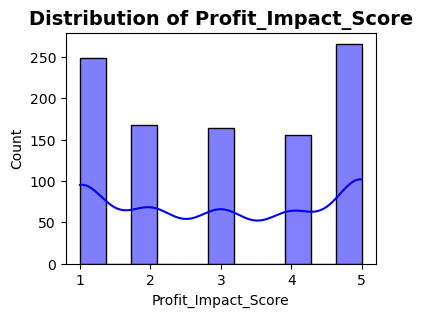

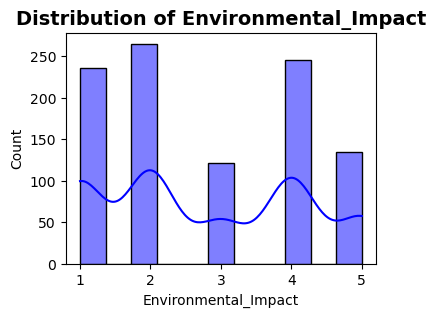

In [26]:
plt.figure(figsize=(4, 3))
sns.histplot(df['Supply_Risk_Score'], kde=True, color='blue')
plt.title('Distribution of Supply_Risk_Score', fontsize=14, fontweight='bold')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['Profit_Impact_Score'], kde=True, color='blue')
plt.title('Distribution of Profit_Impact_Score', fontsize=14, fontweight='bold')
plt.show()

plt.figure(figsize=(4, 3))
sns.histplot(df['Environmental_Impact'], kde=True, color='blue')
plt.title('Distribution of Environmental_Impact', fontsize=14, fontweight='bold')
plt.show()

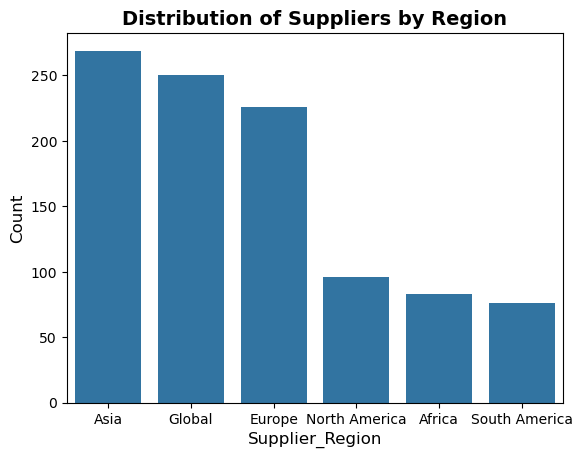

In [27]:
Count_of_Suppliers_by_Region = df['Supplier_Region'].value_counts()
sns.barplot(x=Count_of_Suppliers_by_Region.index, y=Count_of_Suppliers_by_Region.values)
plt.title('Distribution of Suppliers by Region', fontsize=14, fontweight='bold')
plt.xlabel('Supplier_Region', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

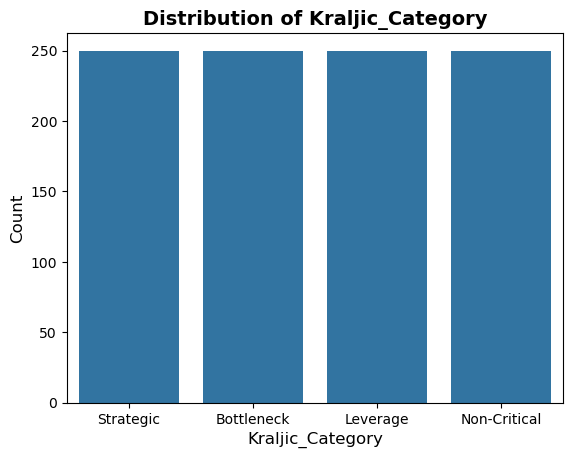

In [28]:
Count_of_Suppliers_by_Region = df['Kraljic_Category'].value_counts()
sns.barplot(x=Count_of_Suppliers_by_Region.index, y=Count_of_Suppliers_by_Region.values)
plt.title('Distribution of Kraljic_Category', fontsize=14, fontweight='bold')
plt.xlabel('Kraljic_Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

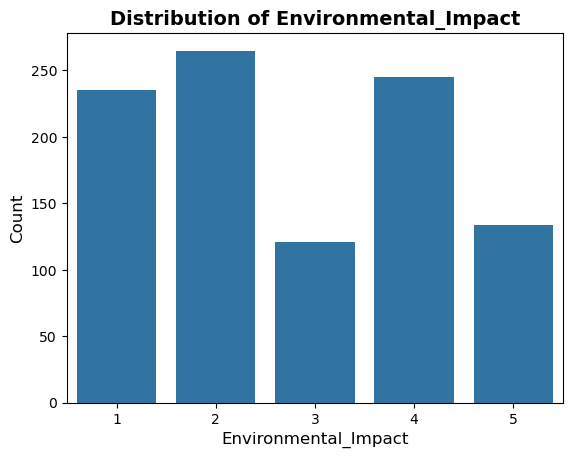

In [29]:
Count_of_Suppliers_by_Region = df['Environmental_Impact'].value_counts()
sns.barplot(x=Count_of_Suppliers_by_Region.index, y=Count_of_Suppliers_by_Region.values)
plt.title('Distribution of Environmental_Impact', fontsize=14, fontweight='bold')
plt.xlabel('Environmental_Impact', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

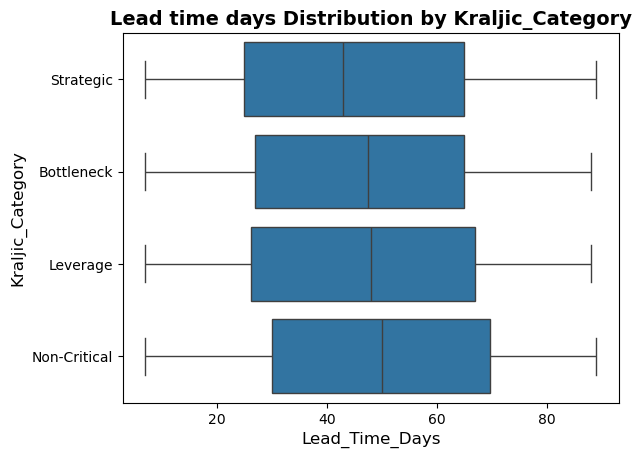

In [30]:
sns.boxplot(data=df, x='Lead_Time_Days', y='Kraljic_Category')
plt.title('Lead time days Distribution by Kraljic_Category', fontsize=14, fontweight='bold')
plt.xlabel('Lead_Time_Days', fontsize=12)
plt.ylabel('Kraljic_Category', fontsize=12)
plt.show()

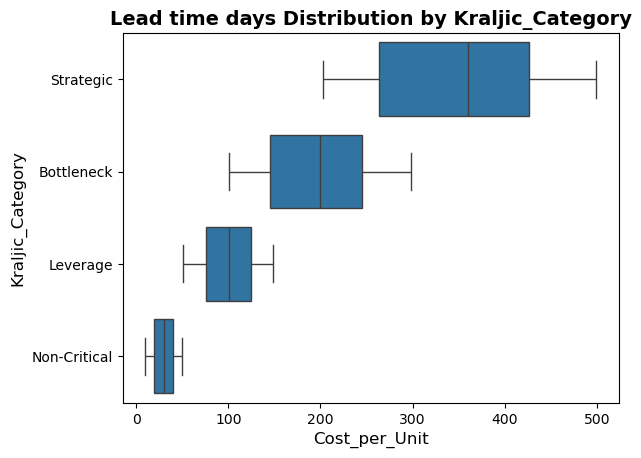

In [31]:
sns.boxplot(data=df, x='Cost_per_Unit', y='Kraljic_Category')
plt.title('Lead time days Distribution by Kraljic_Category', fontsize=14, fontweight='bold')
plt.xlabel('Cost_per_Unit', fontsize=12)
plt.ylabel('Kraljic_Category', fontsize=12)
plt.show()

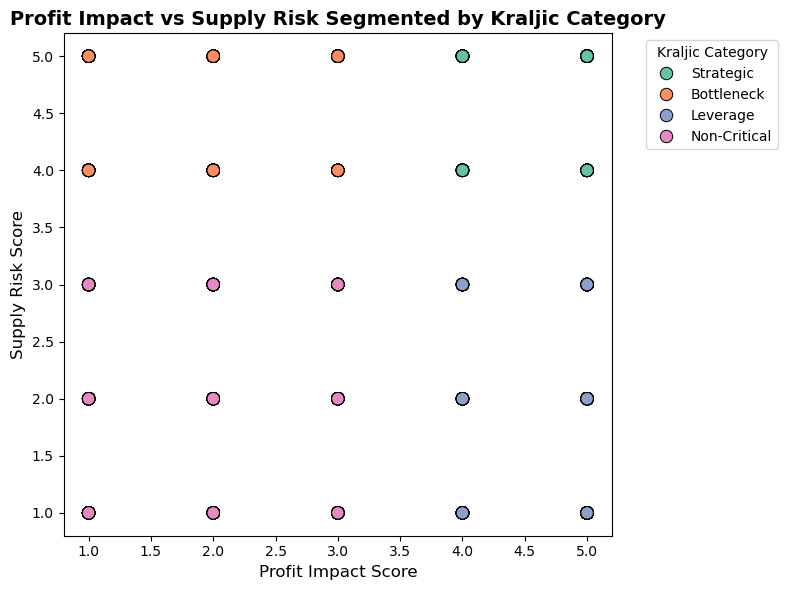

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df,x='Profit_Impact_Score',y='Supply_Risk_Score',hue='Kraljic_Category',palette='Set2',s=80,edgecolor='black')

plt.title('Profit Impact vs Supply Risk Segmented by Kraljic Category', fontsize=14, fontweight='bold')
plt.xlabel('Profit Impact Score', fontsize=12)
plt.ylabel('Supply Risk Score', fontsize=12)
plt.legend(title='Kraljic Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

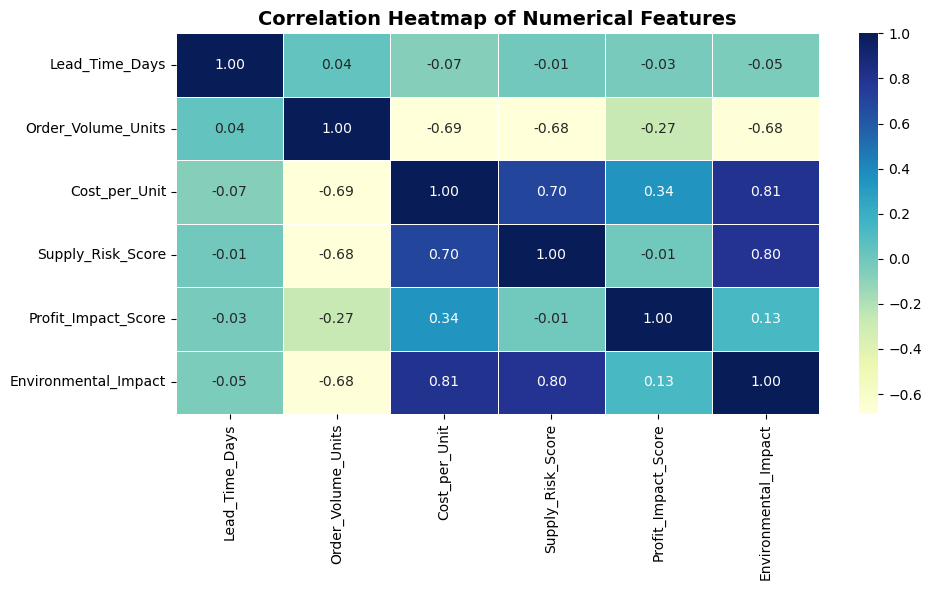

In [33]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix,annot=True,cmap='YlGnBu',fmt='.2f',linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Predictive modeling

### 🎯 Step 1: Separate features & target

In [34]:
X = df.drop('Kraljic_Category', axis=1)
y = df['Kraljic_Category']

In [35]:
# Encode target
le = LabelEncoder()
y = le.fit_transform(y)

### 🔍 Step 2: Define column types

In [36]:
numeric_features = ['Lead_Time_Days', 'Order_Volume_Units', 'Cost_per_Unit',
                    'Supply_Risk_Score', 'Profit_Impact_Score', 'Environmental_Impact']

In [37]:
onehot_features = ['Supplier_Region', 'Single_Source_Risk']
target_encoded_features = ['Product_Name']

### Step 3: Define transformers

In [38]:
target_enc = TargetEncoder(cols=target_encoded_features)

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_features),
        ('target', target_enc, target_encoded_features)
    ]
)

### 🚀 Step 4: Build pipeline

In [40]:
# 1️⃣ Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### 🧠 Step 5: Train-test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 🏋️ Step 6: Fit the model

In [42]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Lead_Time_Days',
                                                   'Order_Volume_Units',
                                                   'Cost_per_Unit',
                                                   'Supply_Risk_Score',
                                                   'Profit_Impact_Score',
                                                   'Environmental_Impact']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Supplier_Region',
                                                   'Single_Source_Risk']),
                                                 ('target',
                                                  TargetEncoder(cols=['Product_Name']),
                                                  ['Product_Name'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### 📈 Step 7: Evaluate performance

In [43]:
y_pred = rf_pipeline.predict(X_test)

[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
              precision    recall  f1-score   support

  Bottleneck       1.00      1.00      1.00        50
    Leverage       1.00      1.00      1.00        50
Non-Critical       1.00      1.00      1.00        50
   Strategic       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



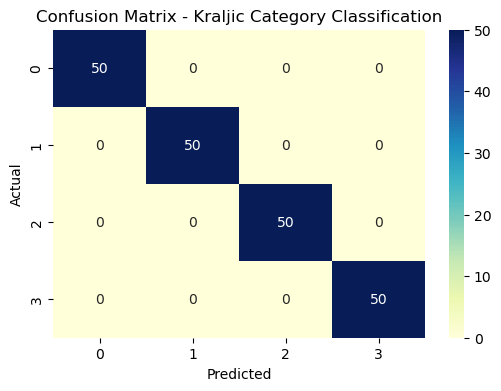

In [44]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Kraljic Category Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Step: Comparison and Evaluation of Classifier Performance

In [46]:
# 2️⃣ XGBoost Random Forest Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBRFClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

In [47]:
xgb_pipeline.fit(X_train, y_train)

C:\Users\Admin\anaconda3\anaconda\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:28:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Lead_Time_Days',
                                                   'Order_Volume_Units',
                                                   'Cost_per_Unit',
                                                   'Supply_Risk_Score',
                                                   'Profit_Impact_Score',
                                                   'Environmental_Impact']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Supplier_Region',
                                                   'Single_Source_Risk']),
                                                 ('target',
                                                  TargetEncoder(cols=['Produ...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=None,
                                 n_jobs=None, num_parallel_tree=None,
                                 objective='multi:softprob', random_state=42, ...))])

In [48]:
y_pred = xgb_pipeline.predict(X_test)

[[50  0  0  0]
 [ 0 47  3  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
              precision    recall  f1-score   support

  Bottleneck       1.00      1.00      1.00        50
    Leverage       1.00      0.94      0.97        50
Non-Critical       0.94      1.00      0.97        50
   Strategic       1.00      1.00      1.00        50

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



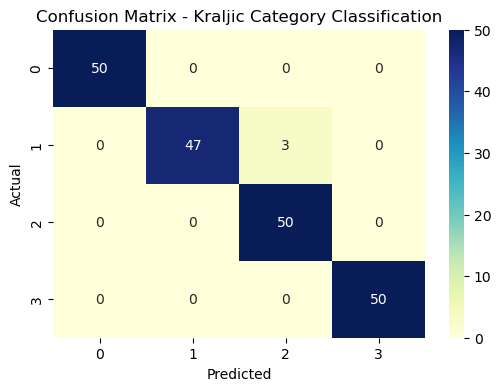

In [49]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Kraljic Category Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
# 3️⃣ K-Nearest Neighbors Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [52]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Lead_Time_Days',
                                                   'Order_Volume_Units',
                                                   'Cost_per_Unit',
                                                   'Supply_Risk_Score',
                                                   'Profit_Impact_Score',
                                                   'Environmental_Impact']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Supplier_Region',
                                                   'Single_Source_Risk']),
                                                 ('target',
                                                  TargetEncoder(cols=['Product_Name']),
                                                  ['Product_Name'])])),
                ('classifier', KNeighborsClassifier())])

In [53]:
y_pred = knn_pipeline.predict(X_test)

[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
              precision    recall  f1-score   support

  Bottleneck       1.00      1.00      1.00        50
    Leverage       1.00      1.00      1.00        50
Non-Critical       1.00      1.00      1.00        50
   Strategic       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



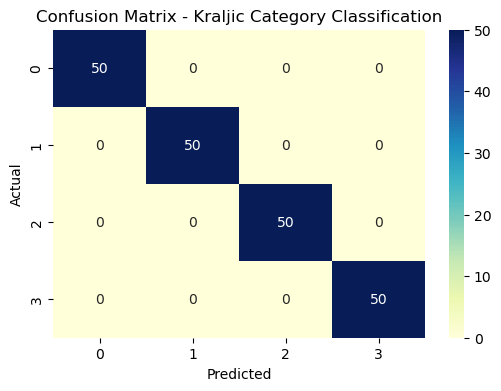

In [54]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Kraljic Category Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
# 4️⃣ Gradient Boosting Pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [56]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Lead_Time_Days',
                                                   'Order_Volume_Units',
                                                   'Cost_per_Unit',
                                                   'Supply_Risk_Score',
                                                   'Profit_Impact_Score',
                                                   'Environmental_Impact']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Supplier_Region',
                                                   'Single_Source_Risk']),
                                                 ('target',
                                                  TargetEncoder(cols=['Product_Name']),
                                                  ['Product_Name'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [57]:
y_pred = gb_pipeline.predict(X_test)

[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
              precision    recall  f1-score   support

  Bottleneck       1.00      1.00      1.00        50
    Leverage       1.00      1.00      1.00        50
Non-Critical       1.00      1.00      1.00        50
   Strategic       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



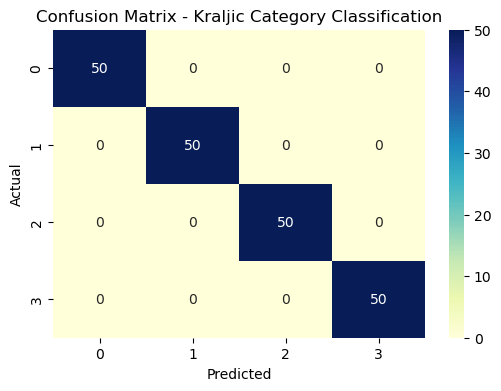

In [58]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Kraljic Category Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [59]:
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

In [60]:
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Lead_Time_Days',
                                                   'Order_Volume_Units',
                                                   'Cost_per_Unit',
                                                   'Supply_Risk_Score',
                                                   'Profit_Impact_Score',
                                                   'Environmental_Impact']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Supplier_Region',
                                                   'Single_Source_Risk']),
                                                 ('target',
                                                  TargetEncoder(cols=['Product_Name']),
                                                  ['Product_Name'])])),
                ('classifier', SVC(probability=True, random_state=42))])

In [61]:
y_pred = svc_pipeline.predict(X_test)

[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
              precision    recall  f1-score   support

  Bottleneck       1.00      1.00      1.00        50
    Leverage       1.00      1.00      1.00        50
Non-Critical       1.00      1.00      1.00        50
   Strategic       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



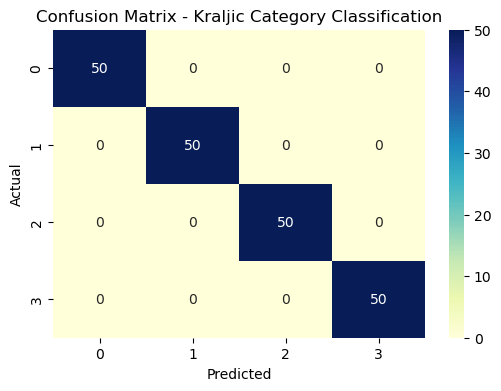

In [62]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Kraljic Category Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
gnb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [64]:
gnb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Lead_Time_Days',
                                                   'Order_Volume_Units',
                                                   'Cost_per_Unit',
                                                   'Supply_Risk_Score',
                                                   'Profit_Impact_Score',
                                                   'Environmental_Impact']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Supplier_Region',
                                                   'Single_Source_Risk']),
                                                 ('target',
                                                  TargetEncoder(cols=['Product_Name']),
                                                  ['Product_Name'])])),
                ('classifier', GaussianNB())])

In [65]:
y_pred = gnb_pipeline.predict(X_test)

[[50  0  0  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 0  0  0 50]]
              precision    recall  f1-score   support

  Bottleneck       1.00      1.00      1.00        50
    Leverage       1.00      1.00      1.00        50
Non-Critical       1.00      1.00      1.00        50
   Strategic       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



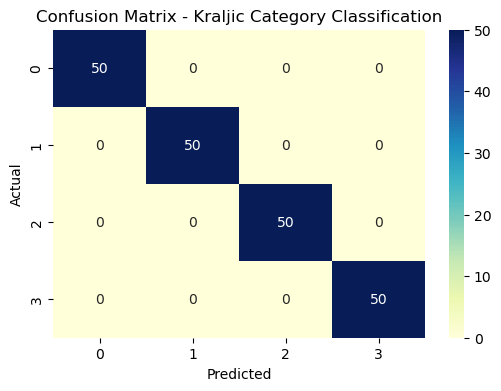

In [66]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Kraljic Category Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 🧠 Step 8: Save the trained model

In [67]:
import joblib

In [68]:
joblib.dump(rf_pipeline, "random_forest_kraljic_model.joblib")
print("✅ Random Forest model saved successfully!")

✅ Random Forest model saved successfully!
